In [45]:
import os, sys, glob
import pickle as pkl
import awkward as ak
import numpy as np
import pandas as pd
import scipy

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
! ls ../python/Dec15tagger/2017/mu_hists_tagger.pkl

../python/Nov23tagger/2017/mu_hists_tagger.pkl


In [6]:
with open('../python/Dec15tagger/2017/mu_hists_tagger.pkl', 'rb') as f:
    data = pkl.load(f)

In [9]:
data.keys()

dict_keys(['fj_pt', 'qcd_score', 'top_score', 'hww_score', 'H/(1-H)', 'H/(H+QCD)', 'H/(H+Top)'])

# Check the inference samples

In [2]:
condor_dir = "/eos/uscms/store/user/cmantill/boostedhiggs/Nov16_inference_2017/"

! ls {condor_dir}

DYJetsToLL_Pt-100To250			 ST_tW_top_5f_inclusiveDecays
DYJetsToLL_Pt-250To400			 ttHToNonbb_M125
DYJetsToLL_Pt-400To650			 TTTo2L2Nu
DYJetsToLL_Pt-50To100			 TTToHadronic
DYJetsToLL_Pt-650ToInf			 TTToSemiLeptonic
GluGluHToWW_Pt-200ToInf_M-125		 VBFHToWWToLNuQQ_M-125_withDipoleRecoil
GluGluHToWWToLNuQQ			 WJetsToLNu_HT-100To200
HWminusJ_HToWW_M-125			 WJetsToLNu_HT-1200To2500
HWplusJ_HToWW_M-125			 WJetsToLNu_HT-200To400
HZJ_HToWW_M-125				 WJetsToLNu_HT-2500ToInf
QCD_Pt_1000to1400			 WJetsToLNu_HT-400To600
QCD_Pt_1400to1800			 WJetsToLNu_HT-600To800
QCD_Pt_170to300				 WJetsToLNu_HT-70To100
QCD_Pt_1800to2400			 WJetsToLNu_HT-800To1200
QCD_Pt_2400to3200			 WJetsToQQ_HT-200to400
QCD_Pt_300to470				 WJetsToQQ_HT-400to600
QCD_Pt_3200toInf			 WJetsToQQ_HT-600to800
QCD_Pt_470to600				 WJetsToQQ_HT-800toInf
QCD_Pt_600to800				 WW
QCD_Pt_800to1000			 WZ
ST_s-channel_4f_hadronicDecays		 ZJetsToQQ_HT-200to400
ST_s-channel_4f_leptonDecays		 ZJetsToQQ_HT-400to600
ST_t-channel_antitop_4f_Inclusive

In [238]:
# pick a sample
sample = "GluGluHToWWToLNuQQ"

! ls {condor_dir}/{sample}/outfiles

0-20_ele.parquet  20-40_ele.parquet  40-60_ele.parquet	60-80_ele.parquet
0-20_mu.parquet   20-40_mu.parquet   40-60_mu.parquet	60-80_mu.parquet
0-20.pkl	  20-40.pkl	     40-60.pkl		60-80.pkl


In [239]:
# use any one parquet file to get the labels/scores as a list
test_parquet = pd.read_parquet(f"{condor_dir}/{sample}/outfiles/0-20_ele.parquet", engine='pyarrow')

labels = []
for key in test_parquet.keys():
    if "label" in key:
        labels.append(key)
        print(key)

fj_label_H_WqqWqq_0c
fj_label_H_WqqWqq_1c
fj_label_H_WqqWqq_2c
fj_label_H_WqqWq_0c
fj_label_H_WqqWq_1c
fj_label_H_WqqWq_2c
fj_label_H_WqqWev_0c
fj_label_H_WqqWev_1c
fj_label_H_WqqWmv_0c
fj_label_H_WqqWmv_1c
fj_label_H_WqqWtauev_0c
fj_label_H_WqqWtauev_1c
fj_label_H_WqqWtaumv_0c
fj_label_H_WqqWtaumv_1c
fj_label_H_WqqWtauhv_0c
fj_label_H_WqqWtauhv_1c
fj_label_H_tauhtaue
fj_label_H_tauhtaum
fj_label_H_tauhtauh
fj_label_QCD_bb
fj_label_QCD_cc
fj_label_QCD_b
fj_label_QCD_c
fj_label_QCD_others
fj_label_Top_bWqq_0c
fj_label_Top_bWqq_1c
fj_label_Top_bWq_0c
fj_label_Top_bWq_1c
fj_label_Top_bWev
fj_label_Top_bWmv
fj_label_Top_bWtauhv
fj_label_Top_bWtauev
fj_label_Top_bWtaumv


In [182]:
def from_parquet_list_to_scores(parquets_):
    """
    Function that takes a list of processed parquet files and combines them under one big dataframe.
    Then it applies a softmax over the labels and combines the QCD, Top, HWW labels seperately.
    
    Args
        list pf parquet files.
    Returns
        three lists [qcd, top, hww]: each containing the respective combined scores.
    """
    
    # combine the parquets into a single dataframe
    df_all = []
    for parquet_ in parquets_:
        d = pd.read_parquet(parquet_, engine='pyarrow')

        if len(d)==0:
            # skip empty dataframes
            continue

        d = d[labels]   # keep only the labels
        if len(df_all)==0:
            df_all = d
        else:
            df_all = pd.concat([df_all, d], ignore_index=True)

    # apply softmax per row
    df_all_softmax = scipy.special.softmax(df_all.values, axis=1)

    print(f"Shape of the combined array: {df_all_softmax.shape}")
    print(f"Number of events: {df_all_softmax.shape[0]}")
    print(f"Number of labels: {df_all_softmax.shape[1]}")
    
    # combine the labels under QCD, TOP or HWW
    qcd, top, hww = np.zeros(len(df_all_softmax)), np.zeros(len(df_all_softmax)), np.zeros(len(df_all_softmax))

    for i, label in enumerate(labels):
        if "QCD" in label:
            qcd += df_all_softmax[:, i]
        elif "Top" in label:
            top += df_all_softmax[:, i]
        else:
            hww += df_all_softmax[:, i]

    return qcd, top, hww

# Get the tagger scores for the HWW samples

In [244]:
sample = "GluGluHToWW_Pt-200ToInf_M-125"

mu_parquets = glob.glob(f"{condor_dir}/{sample}/outfiles/*_mu*.parquet")
ele_parquets = glob.glob(f"{condor_dir}/{sample}/outfiles/*_ele*.parquet")

In [245]:
print("MUON CHANNEL")
qcd_mu, top_mu, hww_mu = from_parquet_list_to_scores(mu_parquets)
print("------------------------")
print("ELECTRON CHANNEL")
qcd_ele, top_ele, hww_ele = from_parquet_list_to_scores(ele_parquets)

MUON CHANNEL
Shape of the combined array: (14901, 33)
Number of events: 14901
Number of labels: 33
------------------------
ELECTRON CHANNEL
Shape of the combined array: (9649, 33)
Number of events: 9649
Number of labels: 33


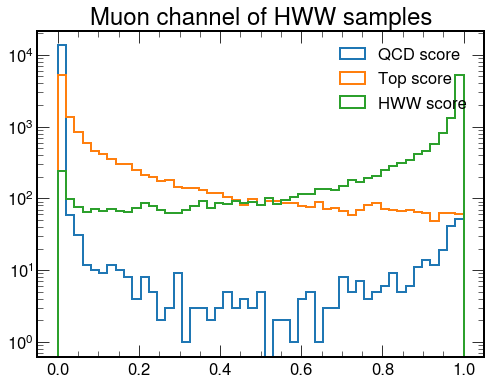

In [246]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_mu, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_mu, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_mu, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Muon channel of HWW samples")
ax.set_yscale('log')
ax.legend();

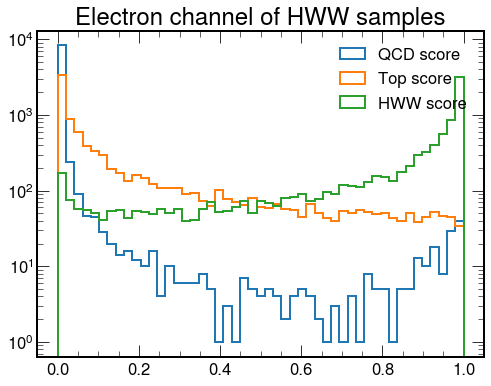

In [247]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_ele, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_ele, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_ele, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Electron channel of HWW samples")
ax.set_yscale('log')
ax.legend();

# Get the tagger scores for the QCD samples

In [248]:
qcd_dirs = glob.glob(f"{condor_dir}/QCD*")

mu_parquets, ele_parquets = [], []
for qcd_dir in qcd_dirs:
    mu_parquets += glob.glob(f"{qcd_dir}/outfiles/*_mu*.parquet")
    ele_parquets += glob.glob(f"{qcd_dir}/outfiles/*_ele*.parquet")

In [249]:
print("MUON CHANNEL")
qcd_mu, top_mu, hww_mu = from_parquet_list_to_scores(mu_parquets)
print("------------------------")
print("ELECTRON CHANNEL")
qcd_ele, top_ele, hww_ele = from_parquet_list_to_scores(ele_parquets)

MUON CHANNEL
Shape of the combined array: (94135, 33)
Number of events: 94135
Number of labels: 33
------------------------
ELECTRON CHANNEL
Shape of the combined array: (11220, 33)
Number of events: 11220
Number of labels: 33


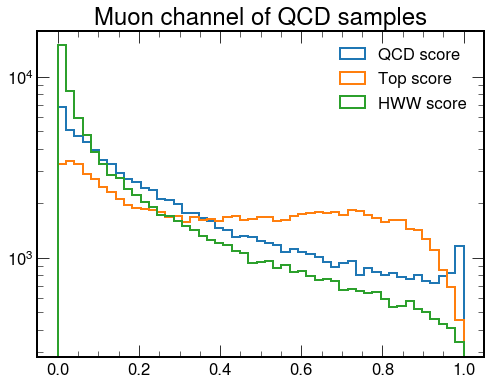

In [250]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_mu, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_mu, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_mu, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Muon channel of QCD samples")
ax.set_yscale('log')
ax.legend();

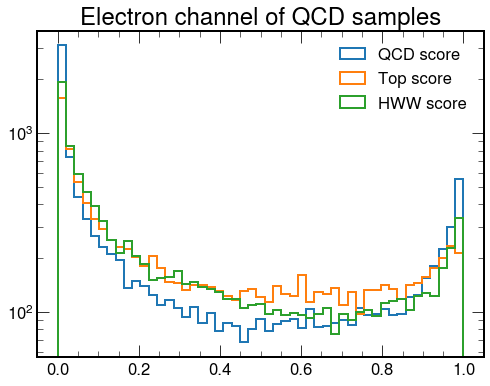

In [251]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_ele, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_ele, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_ele, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Electron channel of QCD samples")
ax.set_yscale('log')
ax.legend();

# Get the tagger scores for the tt samples

In [252]:
TTT_dirs = glob.glob(f"{condor_dir}/TTT*")

mu_parquets, ele_parquets = [], []
for TTT_dir in TTT_dirs:
    mu_parquets += glob.glob(f"{TTT_dir}/outfiles/*_mu*.parquet")
    ele_parquets += glob.glob(f"{TTT_dir}/outfiles/*_ele*.parquet")

In [253]:
print("MUON CHANNEL")
qcd_mu, top_mu, hww_mu = from_parquet_list_to_scores(mu_parquets)
print("------------------------")
print("ELECTRON CHANNEL")
qcd_ele, top_ele, hww_ele = from_parquet_list_to_scores(ele_parquets)

MUON CHANNEL
Shape of the combined array: (1502632, 33)
Number of events: 1502632
Number of labels: 33
------------------------
ELECTRON CHANNEL
Shape of the combined array: (1418195, 33)
Number of events: 1418195
Number of labels: 33


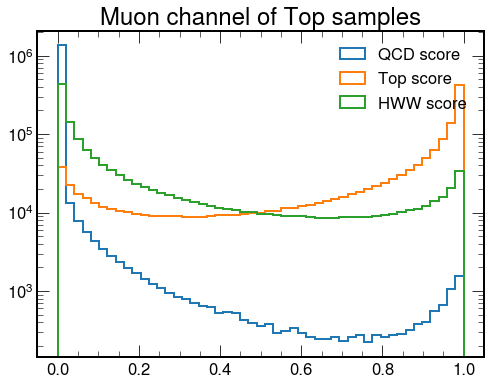

In [254]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_mu, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_mu, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_mu, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Muon channel of Top samples")
ax.set_yscale('log')
ax.legend();

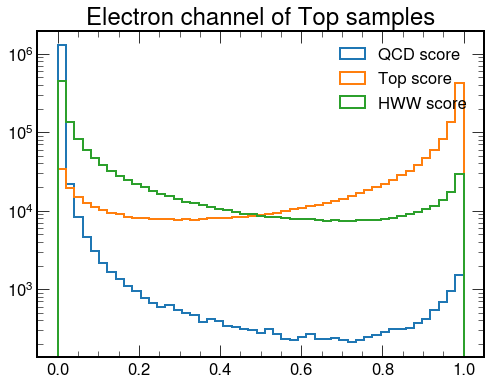

In [255]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(qcd_ele, bins=np.linspace(0,1,50), label="QCD score", histtype='step', linewidth=2)
ax.hist(top_ele, bins=np.linspace(0,1,50), label="Top score", histtype='step', linewidth=2)
ax.hist(hww_ele, bins=np.linspace(0,1,50), label="HWW score", histtype='step', linewidth=2)

ax.set_title("Electron channel of Top samples")
ax.set_yscale('log')
ax.legend();

## Make Roc curves

In [56]:
with open('../python/Dec15tagger/2017/mu_tagger_labels.pkl', 'rb') as f:
    labels = pkl.load(f)
    
with open('../python/Dec15tagger/2017/mu_tagger_scores.pkl', 'rb') as f:
    scores = pkl.load(f)

In [57]:
scores.keys()

dict_keys(['hww_score (H)', 'H/(1-H)', 'H/(H+QCD)', 'H/(H+Top)'])

In [78]:
from sklearn.metrics import auc, roc_curve
def make_roc(labels, scores, ch):

    fig, ax = plt.subplots()
    for key in scores.keys():
        # get nan scores indices
        nan_indices = np.argwhere(np.isnan(scores[key]))

        label = np.delete(np.array(labels), nan_indices)
        score = np.delete(np.array(scores[key]), nan_indices)

        fpr, tpr, _ = roc_curve(label, score)
        roc_auc = auc(fpr, tpr)

        ax.plot(
            tpr,
            fpr,
            lw=2,
            label=f"{key} - AUC = {round(auc(fpr, tpr)*100,2)}%",
        )
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(title=f"{ch} channel", loc="lower right")

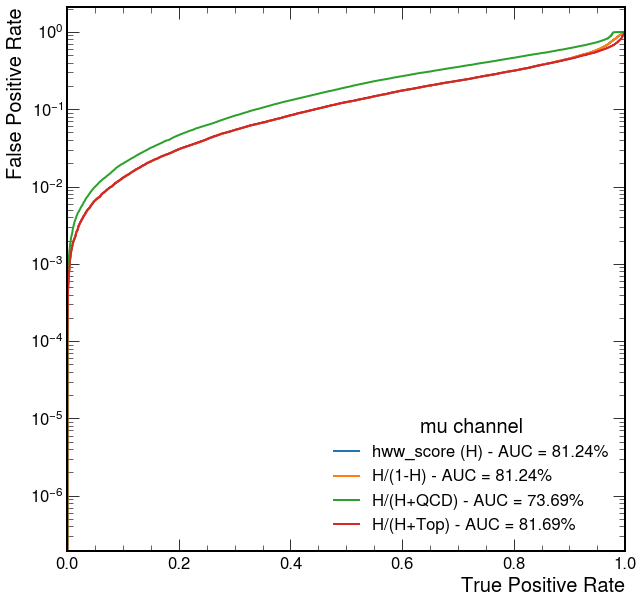

In [80]:
make_roc(labels, scores, "mu")